In [2]:
%matplotlib notebook

import numpy as np
import cv2
import os
import sys
import glob

sys.path.append('../functions/')
sys.path.append('../utils/')

from DoG import DoG
from file_manager import File_manager
from wdd_decoder_functions import create_diff_images, filter_with_kernel, calc_accumulator, calc_angles, read_GT, read_DD, def_orientation

from matplotlib import pyplot as plt
from joblib import Parallel, delayed
from sklearn.linear_model import TheilSenRegressor
from skimage.transform import radon, rescale

from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal

#Radian
radi = np.pi / 180

Covariance
[[ 120.    0.]
 [   0.   30.]]
Rotation Matrix
[[ 0.5       -0.8660254]
 [ 0.8660254  0.5      ]]


<IPython.core.display.Javascript object>


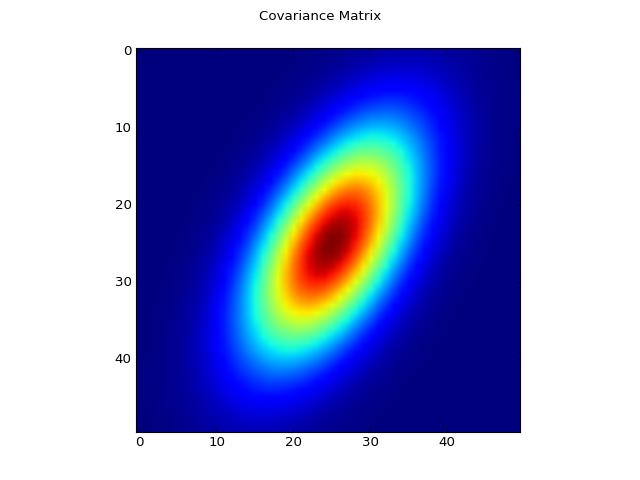

<function matplotlib.pyplot.show>

In [3]:
#Angle
a = 60

#Null matrix
col = 50
row = 50
test = np.zeros(shape=(col, row))

#Covariance
test_cov = 120 * np.eye(2)
test_cov[1][1] = test_cov[1][1] /4
print('Covariance')
print(test_cov)

#Rotation Matrix for angle a
rot = np.array([[np.cos(a * radi), -np.sin(a * radi)],[np.sin(a * radi), np.cos(a * radi)]])
print('Rotation Matrix')
print(rot)
test_cov = np.transpose(rot) @ test_cov @ rot

#Building the covariance matrix nxn
for x in range(col):
    for y in range(row):
        test[y,x] = multivariate_normal.pdf([x, y], mean=(col/2, row/2), cov=test_cov)

#Plotting covariance matrix
fig=plt.figure()
fig.suptitle('Covariance Matrix')
plt.imshow(test)
plt.show

In [4]:
moment = cv2.moments(test)

#Image covariance (central nomarlized moments)
img_cov = np.array([[moment['nu20'], moment['nu11']], [moment['nu11'], moment['nu02']]])
print('Image Covariance')
print(img_cov.astype(int))

#Eigenvalues
w, v = np.linalg.eig(img_cov)

#Eigenvalues
print('Eigenvalues w')
print(w)

#Normalized Eigenvectors
print('Eigenvectors v')
print(v)

#Angle first component
print('FIRST COMPONENT')
print('Eigen value: ')
print(w[np.argmax(w)])
print('Eigen vector: ')
print(v[0][np.argmax(w)])
print(v[1][np.argmax(w)])
print('Angle in degrees (Cartesian)')
angleFC = np.arctan2(v[1][np.argmax(w)], v[0][np.argmax(w)])/radi;
print(angleFC)
print('Angle in degrees (Image)')
print(-angleFC)

#Angle second component
print('SECOND COMPONENT')
print('Eigen value: ')
print(w[np.argmin(w)])
print('Eigen vector: ')
print(v[0][np.argmin(w)])
print(v[1][np.argmin(w)])
print('Angle in degrees (Cartesian)')
angleSC = np.arctan2(v[1][np.argmin(w)], v[0][np.argmin(w)])/radi;
print(angleSC)
print('Angle in degrees (Image)')
print(-np.arctan2(v[1][np.argmin(w)], v[0][np.argmin(w)])/radi)


Image Covariance
[[ 51 -35]
 [-35  90]]
Eigenvalues w
[  30.06005423  111.85181456]
Eigenvectors v
[[-0.85874538  0.51240254]
 [-0.51240254 -0.85874538]]
FIRST COMPONENT
Eigen value: 
111.851814559
Eigen vector: 
0.512402541595
-0.858745384481
Angle in degrees (Cartesian)
-59.1760052458
Angle in degrees (Image)
59.1760052458
SECOND COMPONENT
Eigen value: 
30.0600542263
Eigen vector: 
-0.858745384481
-0.512402541595
Angle in degrees (Cartesian)
-149.176005246
Angle in degrees (Image)
149.176005246


In [5]:
path = '../groundtruth/WDs/'
diff_img = create_diff_images(path)

<IPython.core.display.Javascript object>


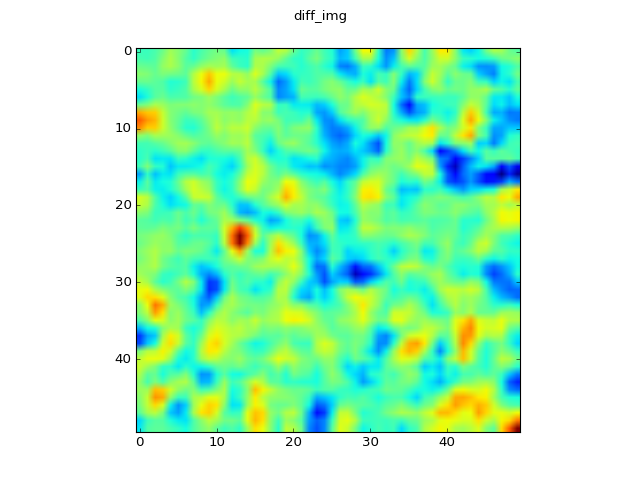

In [6]:
#We take this WRun as an exmaple
pathWR = '../groundtruth/WDs/20160814_1011_1/3/'
fig = plt.figure()
fig.suptitle('diff_img')
plt.imshow(diff_img[pathWR][0], cmap=plt.cm.jet)
plt.show()

In [7]:
FDI = calc_accumulator(diff_img)

<IPython.core.display.Javascript object>


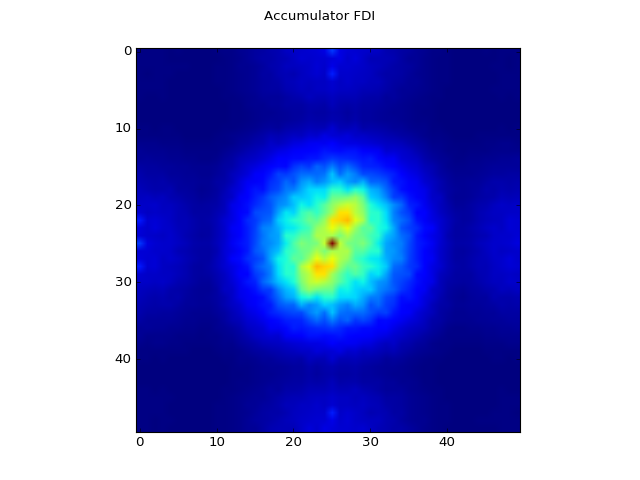

In [8]:
fig = plt.figure()
fig.suptitle('Accumulator FDI')
plt.imshow(FDI[pathWR], cmap=plt.cm.jet)
plt.show()

In [9]:
dog = DoG().mexican_head_kernel

cov1 = 30 * np.eye(2)
cov2 = 4 * np.eye(2)

_dog = abs(np.fft.fftshift(np.fft.fft2(dog(50, [25,25], cov1, [25,25], cov2))))

# print(cov1)
# print(cov2)

# plt.figure()
# plt.imshow(_dog, cmap=plt.cm.jet)
# plt.show()

In [10]:
FDI_filt = filter_with_kernel(FDI,_dog)

<IPython.core.display.Javascript object>


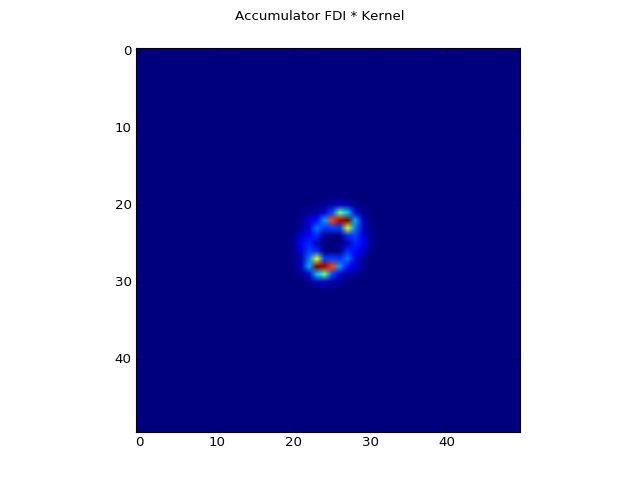

In [11]:
fig = plt.figure()
fig.suptitle('Accumulator FDI * Kernel')
plt.imshow(FDI_filt[pathWR])
plt.show()

In [12]:
angles = calc_angles(FDI)
angles_filt = calc_angles(FDI_filt)

In [13]:
fm_csv = File_manager(path).read_csv
#path to the waggle run
split_keys = pathWR.split("/")
#reads the csv file containing coordinates of dancing bee
detections = fm_csv(pathWR + split_keys[-3] + "_" + split_keys[-2] + '.csv')
#Saschas code parses from csv to vector
detec_as_float = np.array(list(detections.values())[0].split(" "))[:-1].astype(float)
detec_as_float = [val for val in detec_as_float if val != -1]
print(len(detec_as_float))
#first detection
print('first detection')
print(detec_as_float[0], detec_as_float[1])
#last detection
print('last detection')
print(detec_as_float[-2], detec_as_float[-1])

104
first detection
114.7 88.5
last detection
113.4 88.2


In [14]:
#ReadGT
gt_angles = read_GT(path)
#ReadDD
dd_angles = read_DD(path)
#Orientation corrected angles
ct_angles = def_orientation(angles, dd_angles)

In [15]:
print (pathWR)
print ('FastFourier Angle: ' + str(angles[pathWR]))
print ('Corrected Angle:   ' + str(ct_angles[pathWR]))
print ('DotDetector Angle: ' + str(dd_angles[pathWR]))
print ('GroundTruth Angle: ' + str(gt_angles[pathWR]))

print ('CTAngle - DDAngle: ' + str(abs(ct_angles[pathWR]-dd_angles[pathWR])))
print ('GTAngle - DDAngle: ' + str(abs(gt_angles[pathWR]-dd_angles[pathWR])))
print ('CTAngle - GTAngle: ' + str(abs(ct_angles[pathWR]-gt_angles[pathWR])))

../groundtruth/WDs/20160814_1011_1/3/
FastFourier Angle: 158.452433899
Corrected Angle:   -21.5475661013
DotDetector Angle: 57.29577951308232
GroundTruth Angle: -37.1847064532
CTAngle - DDAngle: 78.8433456144
GTAngle - DDAngle: 94.48048596628232
CTAngle - GTAngle: 15.6371403519


In [16]:
for key, angle in list(angles.items()):
    print (key)
    print ('FastFourier Angle: ' + str(angles[key]))
    print ('Corrected Angle:   ' + str(ct_angles[key]))
    print ('DotDetector Angle: ' + str(dd_angles[key]))
    print ('GroundTruth Angle: ' + str(gt_angles[key]))

    print ('CTAngle - DDAngle: ' + str(abs(ct_angles[key]-dd_angles[key])))
    print ('GTAngle - DDAngle: ' + str(abs(gt_angles[key]-dd_angles[key])))
    print ('CTAngle - GTAngle: ' + str(abs(ct_angles[key]-gt_angles[key])))

../groundtruth/WDs/20160814_1010_1/1/
FastFourier Angle: -178.196217472
Corrected Angle:   1.80378252807
DotDetector Angle: 40.10704565915762
GroundTruth Angle: 33.9435870198
CTAngle - DDAngle: 38.3032631311
GTAngle - DDAngle: 6.163458639357621
CTAngle - GTAngle: 32.1398044917
../groundtruth/WDs/20160814_1007_1/5/
FastFourier Angle: -173.560984537
Corrected Angle:   6.43901546324
DotDetector Angle: -68.75493541569878
GroundTruth Angle: 16.2940474566
CTAngle - DDAngle: 75.1939508789
GTAngle - DDAngle: 85.04898287229878
CTAngle - GTAngle: 9.85503199336
../groundtruth/WDs/20160814_1002_1/26/
FastFourier Angle: -103.303297366
Corrected Angle:   76.6967026342
DotDetector Angle: 28.64788975654116
GroundTruth Angle: 17.4747742563
CTAngle - DDAngle: 48.0488128776
GTAngle - DDAngle: 11.17311550024116
CTAngle - GTAngle: 59.2219283779
../groundtruth/WDs/20160814_1007_1/12/
FastFourier Angle: -102.192320187
Corrected Angle:   77.8076798132
DotDetector Angle: 22.91831180523293
GroundTruth Angle: 13